## Implement Kmeans on Players dataset


In [0]:
# just run this chunk of code and follow the prompt that it spits out
# install PyDrive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# import packages
import warnings
import numpy as np
import pandas as pd
import scipy
import scipy.stats as st
import statsmodels as sm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, StandardScaler
import time
import seaborn as sns
import scipy.stats as stats
from sklearn.cluster import KMeans
import pylab as pl
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
import plotly
import plotly.graph_objs as go

In [0]:
# Data importing
# Players file
link = 'https://drive.google.com/open?id=1LZsFQ4jbhwzXRUcVcE1UDRJERa8PCawB'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Players.csv')  
players_df = pd.read_csv('Players.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.



In [0]:
# Calculate the KDA first
# KDA calculation should be Kills + Assists : Death
# If Death is zero, then it should be divided by 0
# So first replace all deaths of 0 to 1
players_df['d'] = players_df['d'].replace(0, 1)
players_df['KDA'] = (players_df['k'] + players_df['a']) / players_df['d']

In [0]:
# Calculate the difference of the gold at 10 and 15
players_df['golddiff'] = players_df['goldat15'] - players_df['goldat10']

In [0]:
# Add one more feature of more than doublekills
# Add only one feature regarding these four columns is because in high-level of competition of the games
# More kills will only happen during the teamfight and it only happened when one team was leading way ahead
# During World competitions, teams are almost the same level, it's very rare to have this kind of situation
players_df['morekills'] = players_df['doubles'] + players_df['triples'] + players_df['quadras'] + players_df['pentas']

According to EDA:
1. 'monsterkillsownjungle' should represent the data for both 'monsterkills' and 'monsterkillsownjungle';
2. 'wards' and 'visionwardbuys' can be represented by 'wards'
3. Remove all the variables used to calculate the new parameters above

In [0]:
# Drop the 'monsterkills' and 'visionwardbuys' columns
players_df = players_df.drop(['k', 'd', 'a', 'goldat10', 'goldat15', 'doubles', 'triples', 'quadras', 'pentas',
                              'monsterkills', 'visionwardbuys'], axis = 1)

In [0]:
# calling categorical variables
categoricalcols = players_df.select_dtypes(include=['object','category'])
print(categoricalcols.columns)

# id columns will not be able to be interpreted for clustering so we need to drop two id columns
# 'ChampType' is also one of the indicator column - categorical column so we need to drop it
# 'fbtime' represents the time parameter instead of the numerical, so this column should also be dropped
# 'fb' represents the indicator whether they killed first baron or not, so it does not belong to numerical data
# According to feature selection, 'goldspent' and 'wardkills' are not listed as an important feature so they should be not used in this case
# Get the Numerical data from the players dataset for PCA and KMeans
players = players_df.drop(['gameid', 'playerid', 'champion','league', 'ban1', 'ban2', 'ban3', 
                              'fb', 'fbassist', 'fbtime', 'visionwards', 'goldspent', 'wardkills'], axis = 1)

Index(['league', 'position', 'champion', 'ban1', 'ban2', 'ban3',
       'visionwards'],
      dtype='object')


## Fit choice clusters with original players data

1. Split data to win and lose
2. Split train and test
3. Get dummies for categorical variables
4. Scale data
5. Choose your K clusters
6. Apply kmeans on train and test

### Get the dummy variables for champtype and category

In [0]:
players['ChampType'] = players_df['ChampType'].astype('category')
players.head(5)

,position,result,dmgtochamps,wards,minionkills,monsterkillsownjungle,xpat10,ChampType,KDA,golddiff,morekills
0,Top,0,8725.0,14.0,231.0,3.0,4669.0,10,0.000000,2164.0,0
1,Jungle,0,4300.0,15.0,15.0,58.0,3134.0,7,0.200000,1531.0,0
2,Middle,0,6698.0,16.0,247.0,1.0,5088.0,3,0.000000,1790.0,0
3,ADC,0,10367.0,10.0,186.0,1.0,3141.0,18,0.333333,1645.0,0
4,Support,0,2269.0,21.0,12.0,0.0,2593.0,24,0.600000,928.0,1


In [0]:
# get dummies for category variables
players_dummy = pd.get_dummies(players, columns=['ChampType','position'])
players_dummy.head(5)

,result,dmgtochamps,wards,minionkills,monsterkillsownjungle,xpat10,KDA,golddiff,morekills,ChampType_1,ChampType_2,ChampType_3,ChampType_4,ChampType_5,ChampType_6,ChampType_7,ChampType_8,ChampType_9,ChampType_10,ChampType_11,ChampType_12,ChampType_13,ChampType_14,ChampType_15,ChampType_16,ChampType_17,ChampType_18,ChampType_19,ChampType_20,ChampType_21,ChampType_22,ChampType_23,ChampType_24,ChampType_25,ChampType_26,ChampType_27,ChampType_28,position_ADC,position_Jungle,position_Middle,position_Support,position_Top
0,0,8725.0,14.0,231.0,3.0,4669.0,0.000000,2164.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,4300.0,15.0,15.0,58.0,3134.0,0.200000,1531.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,6698.0,16.0,247.0,1.0,5088.0,0.000000,1790.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,10367.0,10.0,186.0,1.0,3141.0,0.333333,1645.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,2269.0,21.0,12.0,0.0,2593.0,0.600000,928.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


### **Seperate the players into winning and losing teams**

In [0]:
# Seperate the players into winning and losing teams
win = players_dummy[players_dummy['result'] == 1]
lose = players_dummy[players_dummy['result'] == 0 ]

##### *For winning team*

In [0]:
# Get the winning players without the result column and reset the index
players_win = win.drop('result', axis = 1)
players_win = players_win.reset_index(drop = True)
players_win.head()

,dmgtochamps,wards,minionkills,monsterkillsownjungle,xpat10,KDA,golddiff,morekills,ChampType_1,ChampType_2,ChampType_3,ChampType_4,ChampType_5,ChampType_6,ChampType_7,ChampType_8,ChampType_9,ChampType_10,ChampType_11,ChampType_12,ChampType_13,ChampType_14,ChampType_15,ChampType_16,ChampType_17,ChampType_18,ChampType_19,ChampType_20,ChampType_21,ChampType_22,ChampType_23,ChampType_24,ChampType_25,ChampType_26,ChampType_27,ChampType_28,position_ADC,position_Jungle,position_Middle,position_Support,position_Top
0,7947.0,14.0,223.0,2.0,4677.0,12.0,2155.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,9513.0,16.0,28.0,53.0,3161.0,17.0,2340.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,20774.0,7.0,204.0,7.0,5169.0,16.0,2818.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,13689.0,11.0,230.0,2.0,2984.0,13.0,2348.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2574.0,34.0,8.0,0.0,2816.0,15.0,1909.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


###### Split train and test for the winning team and scale the data

In [0]:
# Split the data to train and test 
players_win_train, players_win_test= train_test_split(players_win, test_size=0.3, random_state=23)

In [0]:
# Scale the data for both train and test winning team data
scaler = StandardScaler()
scaler.fit(players_win_train)
scaled_playerswin_train = scaler.transform(players_win_train)
scaled_playerswin_test = scaler.transform(players_win_test)

###### Get optimal K for players_win_train data

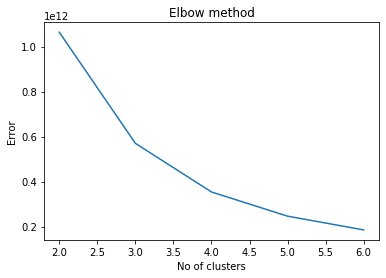

In [0]:
Error =[]
for i in range(2, 7):
    kmeans = KMeans(n_clusters = i).fit(scaled_playerswin_train)
    kmeans.fit(players_win)
    Error.append(kmeans.inertia_)

plt.plot(range(2, 7), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

Apply Kmeans to train

In [0]:
# Apply KMeans with the optimal k to train
kmeans4 = KMeans(n_clusters = 4)
k4win_train = kmeans4.fit(scaled_playerswin_train)

# Predict clusters from train and get the labels for each cluster
y_k4win_train = k4win_train.predict(scaled_playerswin_train)

players_win_train['labels'] = k4win_train.labels_
players_win_train.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,dmgtochamps,wards,minionkills,monsterkillsownjungle,xpat10,KDA,golddiff,morekills,ChampType_1,ChampType_2,ChampType_3,ChampType_4,ChampType_5,ChampType_6,ChampType_7,ChampType_8,ChampType_9,ChampType_10,ChampType_11,ChampType_12,ChampType_13,ChampType_14,ChampType_15,ChampType_16,ChampType_17,ChampType_18,ChampType_19,ChampType_20,ChampType_21,ChampType_22,ChampType_23,ChampType_24,ChampType_25,ChampType_26,ChampType_27,ChampType_28,position_ADC,position_Jungle,position_Middle,position_Support,position_Top,labels
9761,13638.0,35.0,36.0,104.0,3402.0,6.0,1827.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
17085,7957.0,15.0,259.0,4.0,4597.0,5.0,1959.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,3
26270,11378.0,11.0,177.0,13.0,3978.0,4.0,1914.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
28889,6088.0,49.0,53.0,0.0,2642.0,7.0,1678.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
28437,19769.0,22.0,317.0,25.0,4635.0,8.0,2033.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2


In [0]:
# Print out the size and percentages for each cluster for winning train 

size_win_train = pd.DataFrame({'clusters': ['cluster0', 'cluster1', 'cluster2', 'cluster3'],
             'size': [len(players_win_train[players_win_train['labels']==0])/len(players_win_train),
                              len(players_win_train[players_win_train['labels']==1])/len(players_win_train),
                              len(players_win_train[players_win_train['labels']==2])/len(players_win_train),
                              len(players_win_train[players_win_train['labels']==3])/len(players_win_train)]           
             })

In [0]:
# Combine the clusters with original dataframe to interprete results
playerswin_train_ccenters= pd.DataFrame(k4win_train.cluster_centers_, 
                              columns=players_win.columns)
playerswin_train_ccenters2 = playerswin_train_ccenters.T
playerswin_train_ccenters2

,0,1,2,3
dmgtochamps,-0.491183,-0.900782,0.533463,0.429765
wards,0.175478,1.375759,-0.498333,-0.526520
minionkills,-1.141334,-1.082879,0.733017,0.747155
monsterkillsownjungle,1.822552,-0.714437,-0.282175,-0.415931
xpat10,-0.332982,-1.233997,1.191459,0.187270
KDA,-0.003551,-0.034647,0.075576,-0.018763
golddiff,-0.217773,-1.203773,0.568577,0.426509
morekills,-0.228719,-0.482626,0.239638,0.236118
ChampType_1,0.024448,-0.042513,0.097187,-0.039713
ChampType_2,-0.084406,-0.084406,0.198541,-0.014919


###### Get the centers for each cluster and plot the heatmap for the winning team

In [0]:
# Plot each cluster's centers in terms of each variable for winning team
fig = go.Figure()
fig.add_trace(go.Heatmap(z= playerswin_train_ccenters2,
                  y=playerswin_train_ccenters.columns,
                  x=['0','1','2','3'],
                    colorscale='Viridis'))

fig.update_layout(
    autosize=False,
    width=600,
    height=900,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)

fig.show()

###### Apply KMeans to winning test



In [0]:
# Apply to the test data to see the cluster size and check the consistency with the train data
y_k4win_test = k4win_train.predict(scaled_playerswin_test)
players_win_test['labels'] = y_k4win_test

size_win_test = pd.DataFrame({'clusters': ['cluster0', 'cluster1', 'cluster2', 'cluster3'],
             'size': [len(players_win_test[players_win_test['labels']==0])/len(players_win_test),
                              len(players_win_test[players_win_test['labels']==1])/len(players_win_test),
                              len(players_win_test[players_win_test['labels']==2])/len(players_win_test),
                              len(players_win_test[players_win_test['labels']==3])/len(players_win_test)]           
             })

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



###### Combine to see the size for train and test groups

In [0]:
display(size_win_train, size_win_test)

,clusters,size
0,cluster0,0.199164
1,cluster1,0.200636
2,cluster2,0.199924
3,cluster3,0.400275


,clusters,size
0,cluster0,0.201728
1,cluster1,0.194638
2,cluster2,0.206713
3,cluster3,0.396920


##### *For losing team*

In [0]:
# Get the losing players without the result column and reset the index
players_lose = lose.drop('result', axis = 1)
players_lose = players_lose.reset_index(drop = True)
players_lose.head()

,dmgtochamps,wards,minionkills,monsterkillsownjungle,xpat10,KDA,golddiff,morekills,ChampType_1,ChampType_2,ChampType_3,ChampType_4,ChampType_5,ChampType_6,ChampType_7,ChampType_8,ChampType_9,ChampType_10,ChampType_11,ChampType_12,ChampType_13,ChampType_14,ChampType_15,ChampType_16,ChampType_17,ChampType_18,ChampType_19,ChampType_20,ChampType_21,ChampType_22,ChampType_23,ChampType_24,ChampType_25,ChampType_26,ChampType_27,ChampType_28,position_ADC,position_Jungle,position_Middle,position_Support,position_Top
0,8725.0,14.0,231.0,3.0,4669.0,0.000000,2164.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,4300.0,15.0,15.0,58.0,3134.0,0.200000,1531.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,6698.0,16.0,247.0,1.0,5088.0,0.000000,1790.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,10367.0,10.0,186.0,1.0,3141.0,0.333333,1645.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2269.0,21.0,12.0,0.0,2593.0,0.600000,928.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


###### Split train and test for the losing team and scale the data

In [0]:
# Splite the data to train and test 
players_lose_train, players_lose_test= train_test_split(players_lose, test_size=0.3, random_state=23)

# Scale the data for both train and test winning team data
scaler = StandardScaler()
scaler.fit(players_lose_train)
scaled_playerslose_train = scaler.transform(players_lose_train)
scaled_playerslose_test = scaler.transform(players_lose_test)

###### Get optimal K for players_lose_train data

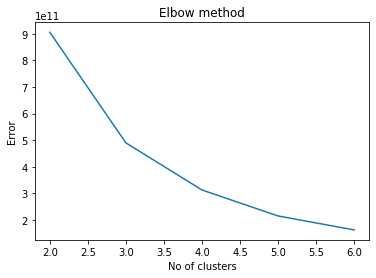

In [0]:
Error =[]
for i in range(2, 7):
    kmeans = KMeans(n_clusters = i).fit(scaled_playerslose_train)
    kmeans.fit(players_lose)
    Error.append(kmeans.inertia_)

plt.plot(range(2, 7), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

###### Apply k means to players_lose_test data

In [0]:
# apply kmeans to losing team test data
kmeans4 = KMeans(n_clusters = 4)
k4lose_train = kmeans4.fit(scaled_playerswin_train)

y_k4lose_train = k4lose_train.predict(scaled_playerslose_train)
players_lose_train['labels'] = k4lose_train.labels_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
# Get the size and percentage of each cluster in losing teams
size_lose_train = pd.DataFrame({'clusters': ['cluster0', 'cluster1', 'cluster2', 'cluster3'],
             'size': [len(players_lose_train[players_lose_train['labels']==0])/len(players_lose_train),
                              len(players_lose_train[players_lose_train['labels']==1])/len(players_lose_train),
                              len(players_lose_train[players_lose_train['labels']==2])/len(players_lose_train),
                              len(players_lose_train[players_lose_train['labels']==3])/len(players_lose_train)]           
             })

In [0]:
playerslose_train_ccenters= pd.DataFrame(k4lose_train.cluster_centers_, 
                              columns=players_lose.columns)
playerslose_train_ccenters2 = playerslose_train_ccenters.T
playerslose_train_ccenters2

,0,1,2,3
dmgtochamps,-0.899715,0.874149,-0.492077,0.413008
wards,1.371790,-0.615941,0.176309,-0.505103
minionkills,-1.081187,0.890866,-1.142108,0.724516
monsterkillsownjungle,-0.714247,-0.240977,1.822921,-0.387230
xpat10,-1.233443,-0.548844,-0.333413,0.661460
KDA,-0.033896,0.203811,-0.003614,-0.011971
golddiff,-1.201387,0.614928,-0.219038,0.457060
morekills,-0.482738,0.510720,-0.228790,0.202964
ChampType_1,-0.042513,-0.042513,0.024495,0.012249
ChampType_2,-0.084406,-0.084406,-0.084406,0.074501


###### Get the centers for each cluster and plot the heatmap for the losing team

In [0]:
# Plot each cluster's centers in terms of each variable for losing team
fig = go.Figure()
fig.add_trace(go.Heatmap(z= playerslose_train_ccenters2,
                  x=['0','1','2','3'],
                  y=playerslose_train_ccenters.columns,
                    colorscale='Viridis'))

fig.update_layout(
    autosize=False,
    width=600,
    height=900,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)

fig.show()

###### Apply k means to losing test

In [0]:
# Apply to the test data to see the cluster size and check the consistency with the train data
y_k4lose_test = k4lose_train.predict(scaled_playerslose_test)
players_lose_test['labels'] = y_k4lose_test

size_lose_test = pd.DataFrame({'clusters': ['cluster0', 'cluster1', 'cluster2', 'cluster3'],
             'size': [len(players_lose_test[players_lose_test['labels']==0])/len(players_lose_test),
                              len(players_lose_test[players_lose_test['labels']==1])/len(players_lose_test),
                              len(players_lose_test[players_lose_test['labels']==2])/len(players_lose_test),
                              len(players_lose_test[players_lose_test['labels']==3])/len(players_lose_test)]           
             })

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
display(size_lose_train, size_lose_test)

,clusters,size
0,cluster0,0.200399
1,cluster1,0.068081
2,cluster2,0.200351
3,cluster3,0.531168


,clusters,size
0,cluster0,0.205384
1,cluster1,0.073003
2,cluster2,0.195635
3,cluster3,0.525978
